# Comparing a naive neural net using word embeddings to a linear model for prediction of cholesterol content of foods

In [1]:
import sys
import os
from operator import itemgetter
import _pickle as pkl
import random
import pandas
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import *
# from sklearn.linear_model import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib import learn
import gensim
import tflearn

/home/andylane/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

## Load data
These were previously collected from a collection of recipes with cholesterol information.

In [2]:
# Load pre-trained Google News word vector embeddings
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
 
# Load the traning/test data
words = pkl.load(open("tf_data/training_data_names.pkl", "rb")) # this is a stemmed/tokenized version
X = pkl.load(open("tf_data/training_data_names_unstemmed.pkl", "rb")) # Recipe names
y = pkl.load(open("tf_data/training_labels_num.pkl", "rb")) # Corresponding cholesterol content for each recipe

# Slice out 20% for test data. This isn't random. OK for development, but need to go back and check later.
X_test = X[3152:]
y_test = y[3152:]

# The rest is the training data
X = X[:3152]
y = y[:3152]

# We also have some alternative test data from chain restaurant menus, but there are issues
# with testing the model on this. Explain in blog.
ground_truth_X = pkl.load(open("tf_data/test_data_names.pkl", "rb"))
ground_truth_y = pkl.load(open("tf_data/test_labels_num.pkl", "rb"))

In [ ]:
# This time we're carrying out the prediction as a regression
# rather than a classification. To start with, an r2 of 
# predicted vs true test cholesterol is used as a metric; the MSE
# is also used.
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [ ]:
# Notes to self:
## There are 300,000 words in the Google News model
len(model.vocab)

## Get words from given index
model.wv.index2word[2898]
# Out: 'judges"

## Find the odd word out:
model.doesnt_match(X[3].split())

## Access recipes:
print(X[3])
print(words[3])

## Get the similarity between two phrases. This is implemented in gensim as
## just the cosine similarity of the means of the two vectors
model.n_similarity(X[3].split(), X[7].split())
model.similarity("saucepan", "food")

## There's a case for n-gramming with underscores:
model.most_similar(["cinnamon", "roll"])
# Out e.g.: coconut_flakes, graham_cracker_crumbs
model.most_similar("cinnamon_roll")
# Out e.g.: cinnamon_rolls, oatmeal_cookie, peach_pie

In [ ]:
# Remove words that are not in the Google News model
# TODO: Also remove stopwords - not necessary to average e.g. "in"
def prune_words_not_found_in_model(X, y):
    filtered_x = []
    filtered_y = []
    for index, recipe in enumerate(X):
        recipe_words = recipe.split()
        recipe_words = list(filter(lambda x: x in model.vocab, recipe_words))
        if len(recipe_words) > 0: #don't add empty lists - the LinReg can't fit NaNs
            filtered_x.append(recipe_words)
            filtered_y.append(y[index]) # to keep y_ same index
        else:
            None
    return filtered_x, filtered_y

In [ ]:
def input_preprocessor(dish, model=model, foodfilter=True):
    '''
    filter for words that are in the model and extract bigrams
    also optionally only keep words above a cosine similarity
    threshold with the word "food".
    Usage: input_preprocessor(dish). Returns np.array of size model dimensions 
        (300 dimensions for GoogleNews Word2Vec model)
    dish: list of words in recipe title
    model: a word2vec model
    ''' 
    # Construct n-grams of pairs of words
    ngrammed = []
    ngrammed.extend(dish)
    for index, word in enumerate(dish):
        if index+1 < len(dish):
            ngrammed.append(word + "_" + dish[index+1])
    # Duplicate words in a dish won't help the model
    ngrammed = set(ngrammed)
    # only include words that have a cosine similarity with the word "food" above a certain threshold
    # better idea: weight them against cosine similarity to food!
    if foodfilter == True:
        foodywords = list(filter(lambda x: x in model.vocab and model.similarity(x, "food") > 0.16, ngrammed))
        # if no words are that close to food, pick the top two words
        if len(foodywords) == 0:
            sims = []
            for x in ngrammed:
                if x in model.vocab:
                    sims.append((x, model.similarity(x, "food")))
            foodywords = [word for word, similarity in sorted(sims, key=itemgetter(1))[:2]]
        foodywords = set(foodywords)
    elif foodfilter == False: # don't filter based on similarity to a food
        foodywords = list(filter(lambda x: x in model.vocab, ngrammed))
    # Return the average of all the foody-word vectors in the recipe name
    return np.array([model[w] for w in foodywords]).mean(axis=0)

In [ ]:
# Apply the input preprocessor across the filtered list of recipes
def prune_and_preprocess(X, y, foodfilter=True):
    filtered_x, filtered_y  = prune_words_not_found_in_model(X, y)
    filtered_x_vect = []
    for index, i in enumerate(filtered_x):
        filtered_x_vect.append(input_preprocessor(i, model, foodfilter=foodfilter))
    filtered_x_vect = np.array(filtered_x_vect)
    filtered_y = np.array([filtered_y]).transpose()
    filtered_y = np.array(filtered_y)
    return filtered_x_vect, filtered_y

In [ ]:
filtered_x_vect, filtered_y = prune_and_preprocess(X, y, foodfilter=False)

In [ ]:
X_test_vect, y_test_vect = prune_and_preprocess(X_test, y_test, foodfilter=False)

In [ ]:
print(filtered_x_vect.shape)
print(filtered_y.shape)

In [ ]:
def test_every_n_epoch(model, n_epochs, total_epochs, filename=None):
    epoch = 0
    result = {"history": np.array(y_test_vect),
              "epoch": ["truth"],
              "truth": y_test_vect
             }
    
    while epoch < total_epochs:
        epoch += n_epochs
        model.fit(filtered_x_vect, filtered_y, batch_size = 16, n_epoch = n_epochs, show_metric=True)
        result["history"] = np.c_[result["history"], dnnmodel.predict(X_test_vect)]
        result["epoch"].append(epoch)
        if filename != None:
            pkl.dump(result, open(str("dnn_models/" + filename + "_resultsdict.pkl"), "wb"))
            model.save(str("dnn_models/" + filename + ".tflearn"))
    return result, model


In [ ]:
def plot_test_epochs(model, result_, subset=None):
    i = 1
    if subset != None:
        result_["history"] = np.take(result_["history"], range(0, len(result_["epoch"]), subset), axis=1)
        result_["epoch"] = result_["epoch"][::subset]
    while i < result_["history"].shape[1]:
        plt.plot(result_["history"][:,0], result_["history"][:,i], 'r.')
        plt.ylabel('y_')
        plt.xlabel('y')
        plt.show()
        print("Epoch " + str(result_["epoch"][i]) + ": R2 = " + str(rsquared(result_["history"][:,0], result_["history"][:,i])))
        print("Epoch " + str(result_["epoch"][i]) + ": MSE = " + str(mean_squared_error(result_["history"][:,0], result_["history"][:,i])))
        i+= 1
#     return result["epoch"]

In [ ]:
def rsquared_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(rsquared(epoch_result, truth))
    print(max(out))
    return out

def mse_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(mean_squared_error(epoch_result, truth))
    print(min(out))
    return out


## Train a network

In [18]:
nodes = 10
tf.reset_default_graph()
tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
#net = tflearn.fully_connected(net, nodes, activation='linear') 
net = tflearn.conv_1d(net, 1, 1, activation='linear') 

net = tflearn.fully_connected(net, nodes, activation='linear') 
net = tflearn.fully_connected(net, nodes, activation="tanh", regularizer="L2")
net = tflearn.fully_connected(net, nodes, activation='linear') 
net = tflearn.fully_connected(net, nodes, activation="relu")#, regularizer="L2")
net = tflearn.fully_connected(net, 1, activation='linear') 
#net = tflearn.dropout(net, 0.5) #was 0.9
net = tflearn.regression(net, optimizer="adam",loss="mean_square", metric="R2", learning_rate=0.001) #was 0.001

dnnmodel = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir="graph")
#dnnmodel = tflearn.DNN(net)

#dnnmodel.load("dnn_models/dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax.tflearn")
#dnnmodel.fit(filtered_x_vect, filtered_y, validation_set=0.2, batch_size = 16, n_epoch = 20, show_metric=True)
#print(rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect[3152:])], [i[0] for i in filtered_y[3152:]]))

AssertionError: Incoming Tensor shape must be 3-D

In [16]:
result, dnnmodel = test_every_n_epoch(dnnmodel, 5, 100)

Training Step: 19699  | total loss: 2049.76440 | time: 0.739s
| Adam | epoch: 100 | loss: 2049.76440 - R2: 0.8727 -- iter: 3136/3150
Training Step: 19700  | total loss: 1962.33765 | time: 0.742s
| Adam | epoch: 100 | loss: 1962.33765 - R2: 0.8865 -- iter: 3150/3150
--


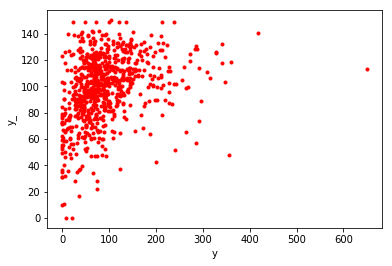

Epoch 5: R2 = 0.100765384932
Epoch 5: MSE = 4097.27925344


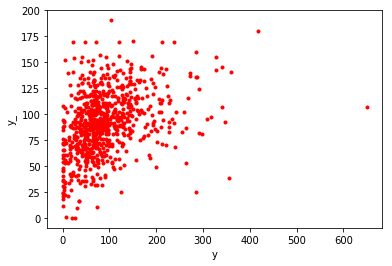

Epoch 10: R2 = 0.12461573963
Epoch 10: MSE = 3956.60765577


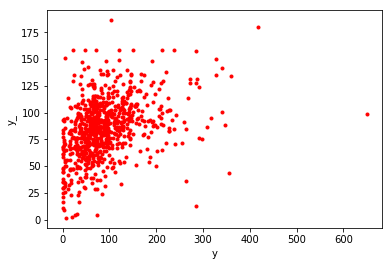

Epoch 15: R2 = 0.140796084433
Epoch 15: MSE = 3876.5868298


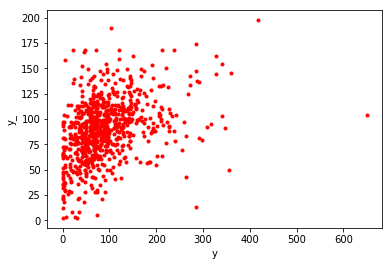

Epoch 20: R2 = 0.141914560828
Epoch 20: MSE = 3858.23297677


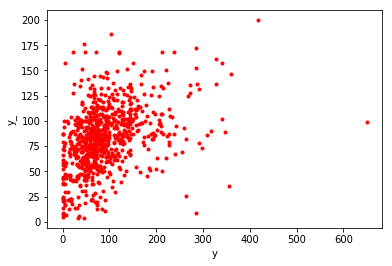

Epoch 25: R2 = 0.149172460341
Epoch 25: MSE = 3895.22887287


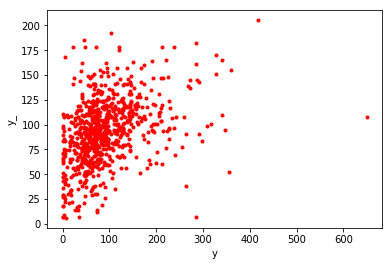

Epoch 30: R2 = 0.145118472704
Epoch 30: MSE = 3876.02381907


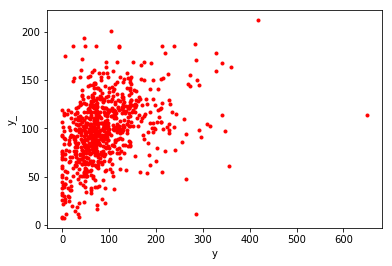

Epoch 35: R2 = 0.144013109243
Epoch 35: MSE = 3951.68509514


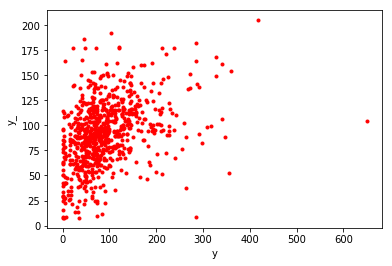

Epoch 40: R2 = 0.14141396672
Epoch 40: MSE = 3890.61176458


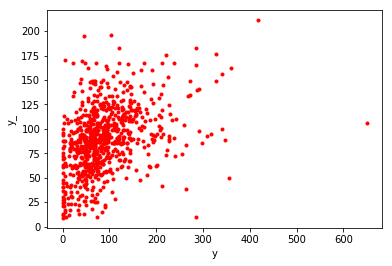

Epoch 45: R2 = 0.14255284325
Epoch 45: MSE = 3896.67828447


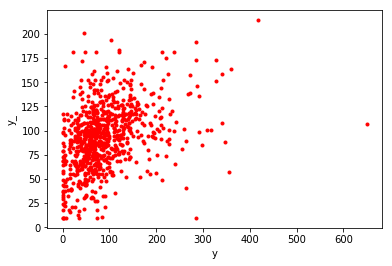

Epoch 50: R2 = 0.142061705262
Epoch 50: MSE = 3914.06953681


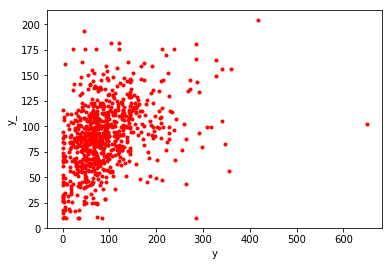

Epoch 55: R2 = 0.144064794314
Epoch 55: MSE = 3876.18708839


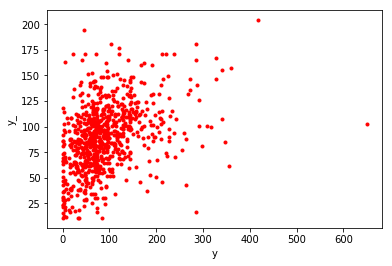

Epoch 60: R2 = 0.146923598307
Epoch 60: MSE = 3857.27908766


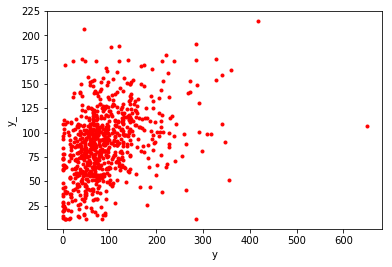

Epoch 65: R2 = 0.14478840198
Epoch 65: MSE = 3926.49912257


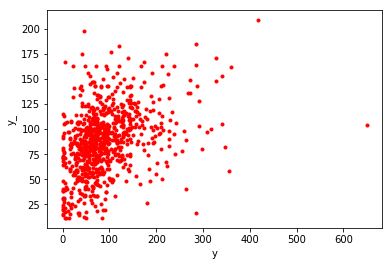

Epoch 70: R2 = 0.142071999847
Epoch 70: MSE = 3908.26143492


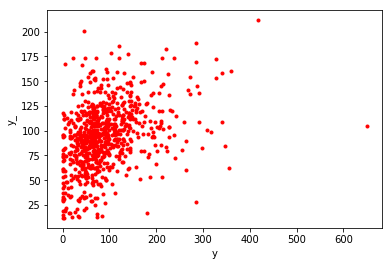

Epoch 75: R2 = 0.134510086126
Epoch 75: MSE = 3953.19037876


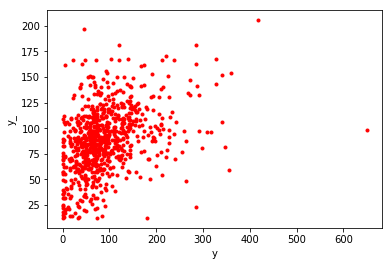

Epoch 80: R2 = 0.140966598977
Epoch 80: MSE = 3887.04516519


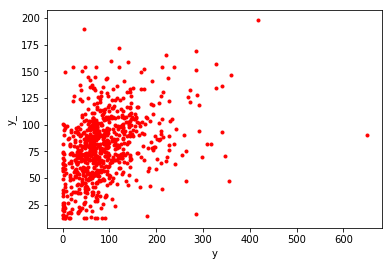

Epoch 85: R2 = 0.137766480172
Epoch 85: MSE = 4016.48287705


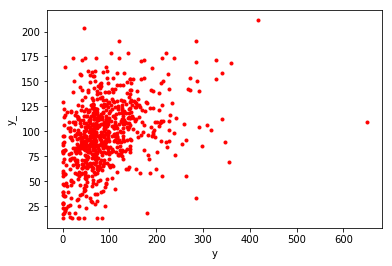

Epoch 90: R2 = 0.135250033464
Epoch 90: MSE = 3978.22711767


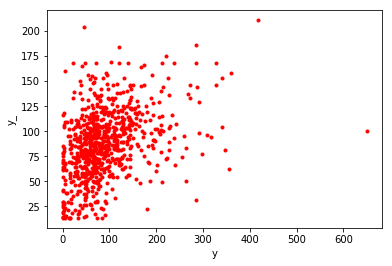

Epoch 95: R2 = 0.14280756181
Epoch 95: MSE = 3907.56806798


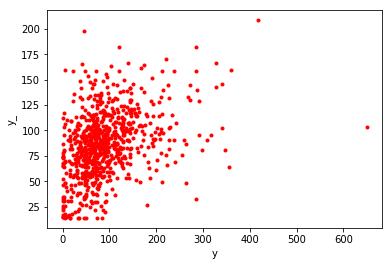

Epoch 100: R2 = 0.143666122046
Epoch 100: MSE = 3887.02516612


In [17]:
plot_test_epochs(dnnmodel, result, subset = 1)

## Having iteratively developed the network topology, load and compare several models:

In [23]:
# First load the model result pickles
model_results = []
i = 0
for filename in os.listdir("dnn_models"):
    path = str("dnn_models/" + filename)
    if ".pkl" in filename:
        model_results.append({"results": pkl.load(open(path, "rb")),
                              "file": filename,
                              "id": i})
        #print(path)
        #print(model_results[i]["results"]["history"][-1,])
        i += 1

# Then plot model metrics
def summarize_model(model_from_file):
    ''' 
    Produce plots summarizing r2 and MSE at each epoch for each model
    Also prints minimum MSE and max r2 for each model
    '''
    print(model_from_file["file"])
    print(model_from_file["id"])
    plt.plot(model_from_file["results"]["epoch"][1:],rsquared_one_to_many(model_from_file["results"]), 'r.')
    plt.ylabel('r2')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(model_from_file["results"]["epoch"][1:],mse_one_to_many(model_from_file["results"]), 'b.')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_resultsdict.pkl
0
0.177343308397


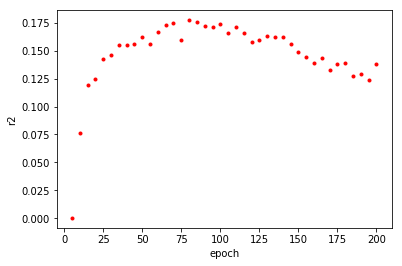

3709.34150188


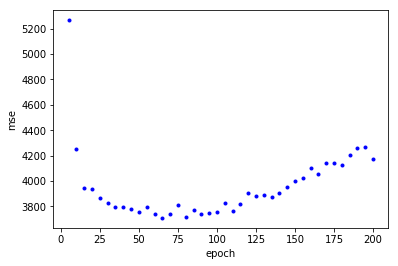

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_L2linear_resultsdict.pkl
1
0.170911474106


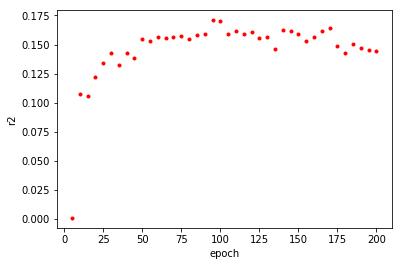

5649.79400907


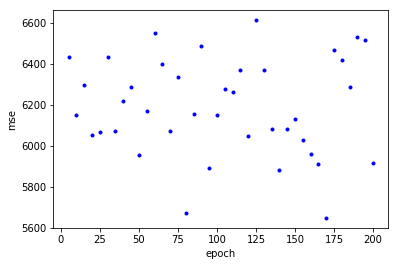

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_resultsdict.pkl
2
0.175499922788


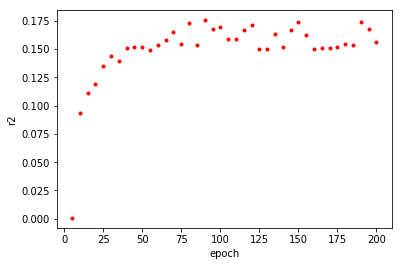

5739.98832438


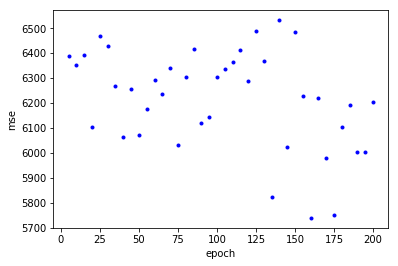

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_L2linear_removed_weightdecay_resultsdict.pkl
3
0.179757167659


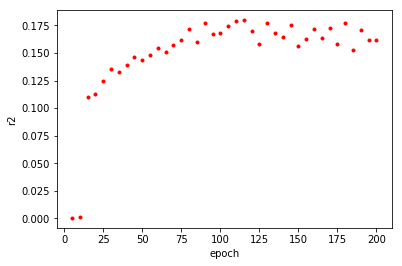

5863.4197824


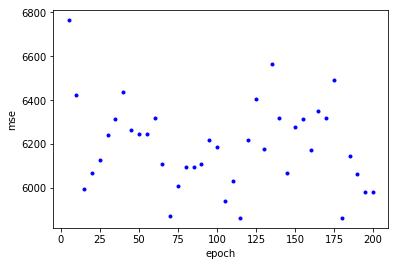

dnn_10node_200epoch_fewer_layers_80pcttrain_resultsdict.pkl
4
0.146380378945


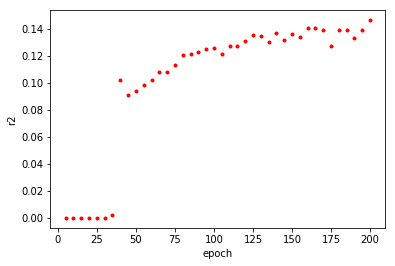

3914.18509503


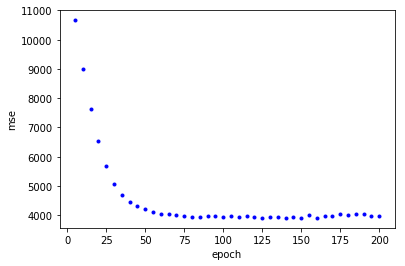

dnn_10node_200epoch_fewer_layers_plus_relu_80pcttrain_resultsdict.pkl
5
0.00251683056308


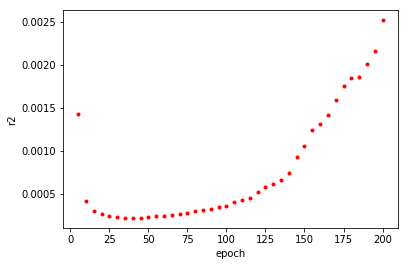

4469.27458442


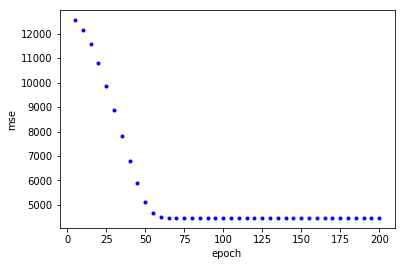

dnn_10node_200epoch_80pcttrain_resultsdict.pkl
6
0.155343263592


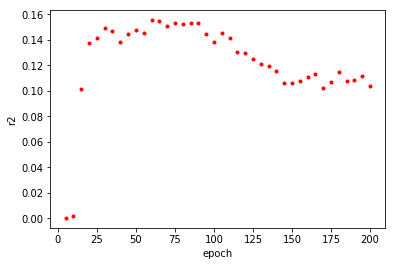

3836.52690912


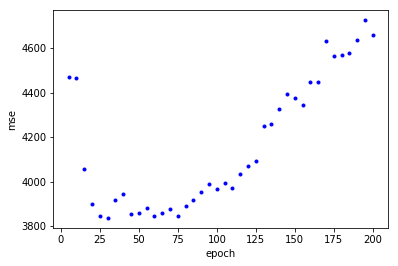

dnn_300node_2000epoch_80pcttrain_resultsdict.pkl
7
0.154742031311


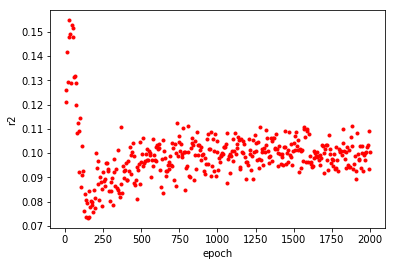

3891.79520948


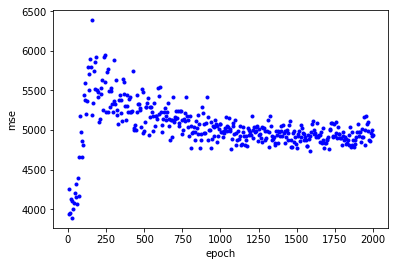

In [211]:
for m in model_results:
    summarize_model(m)

The best model so far is a three-hidden-layer architecture, with 10 nodes in each of tanh/relu/linear layers

Achieves MSE of ~3600 and R2 of ~0.18

## **Comparison to a linear regression**

In [79]:
import sklearn
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [80]:
linregX = pkl.load(open("tf_data/training_data_names.pkl", "rb"))
linregy = pkl.load(open("tf_data/training_labels_num.pkl", "rb"))

In [81]:
# One-hot encode vocab
vectorizer = CountVectorizer(linregX, ngram_range=(1,2))
lrX = vectorizer.fit_transform(linregX)
# Fit a model - LassoCV attempts to pick best L1 regularization
# Model is trained on 80% of data
linreg = linear_model.LassoCV()
linreg.fit(X=lrX[:int(len(linregy)*0.8)].toarray(), y=linregy[:int(len(linregy)*0.8)])

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [82]:
# How well does model predict training data
print("R2 on training data is " + str(rsquared(linreg.predict(lrX), linregy)))
print("R2 on test data is " + str(rsquared(linreg.predict(lrX[int(len(linregy)*0.8):]), linregy[int(len(linregy)*0.8):])))
print("MSE on training data is " + str(mean_squared_error(linreg.predict(lrX), linregy)))
print("MSE on test data is " + str(mean_squared_error(linreg.predict(lrX[int(len(linregy)*0.8):]), linregy[int(len(linregy)*0.8):])))


R2 on training data is 0.437429307758
R2 on test data is 0.246521381684
MSE on training data is 2697.88620597
MSE on test data is 3378.1952728


While the Lasso model with cross validation of regularization parameters (i.e. scikit-learn's LassoCV) does predict the test samples OK, its increased error on
the test data suggests that there's still some degree of overfitting.

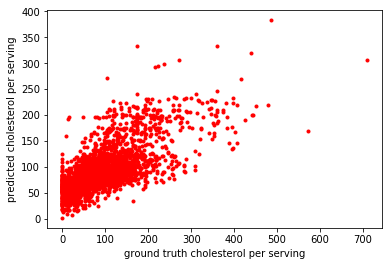

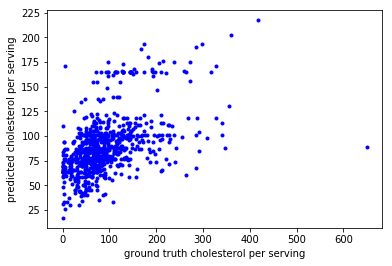

In [74]:
# How well does model predict the test data?
import matplotlib.pyplot as plt
plt.plot(linregy[:int(len(linregy)*0.8)], linreg.predict(lrX[:int(len(linregy)*0.8)]), 'r.')
plt.ylabel('predicted cholesterol per serving')
plt.xlabel('ground truth cholesterol per serving')
plt.show()

# How well does model predict the test data?
import matplotlib.pyplot as plt
plt.plot(linregy[int(len(linregy)*0.8):], linreg.predict(lrX[int(len(linregy)*0.8):]), 'b.')
plt.ylabel('predicted cholesterol per serving')
plt.xlabel('ground truth cholesterol per serving')
plt.show()

## Summary:
1. The MSE and R2 for the optimized linear models is so far superior to the best-performing neural net. However,
being trained on word vectors means that the neural net can predict out-of-sample cholesterol - e.g. for items on a 
menu not contained in the training database, though this is difficult to validate. We'd likely need far more data 
to fully exploit the deep neural nets.

2. There's a lot of work to be done in further exploring the tensorflow models:

    a. Can we optimize the tensorflow model's input data? So far, we took the simplest approach of averaging 
    the vectors of all the words in each food item's name. This is destructive. Can we either learn the relevant
    words or help the model by applying a heuristic?
    
    b. Other network architectures might improve the model somewhat
    
    c. The neural net's loss function - mean squared error - may not be optimal, as it optimizes for minimum error
    across the entire batch at each epoch. We care more about accurately predicting extreme values - avoiding
    high cholesterol items on a menu - than overall fit. Perhaps recasting as a classification problem is the right 
    way to go here, as in the original MenuSights?